In [394]:
import time
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

import numpy as np

import astropy.units as u
from astropy import stats, wcs
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.coordinates import SkyCoord

from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT
import poppy
import photutils

In [2]:
%load_ext autoreload
%autoreload 2

In [61]:
sys.path.append("/Users/tim/src/cwfs/python")
%cd /Users/tim/MMT/61_inch/20190221

/Users/tim/MMT/61_inch/20190221


In [4]:
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile
import lsst.cwfs.plots as plots

In [209]:
r = 50
x = 180
y = 392
intra_whole = fits.open("focus0000.fits")[1].data # focus = 2038
extra_whole = fits.open("focus0001.fits")[1].data # focus = 3236
#intra = intra_whole[942-18:942+18,158-18:158+18] - np.median(intra_whole)
#extra = extra_whole[945-18:945+18,154-18:154+18] - np.median(extra_whole)
intra = intra_whole[y-r:y+r,x-r:x+r] - np.median(intra_whole)
extra = extra_whole[y-r:y+r,x-r:x+r] - np.median(extra_whole)

<IPython.core.display.Javascript object>


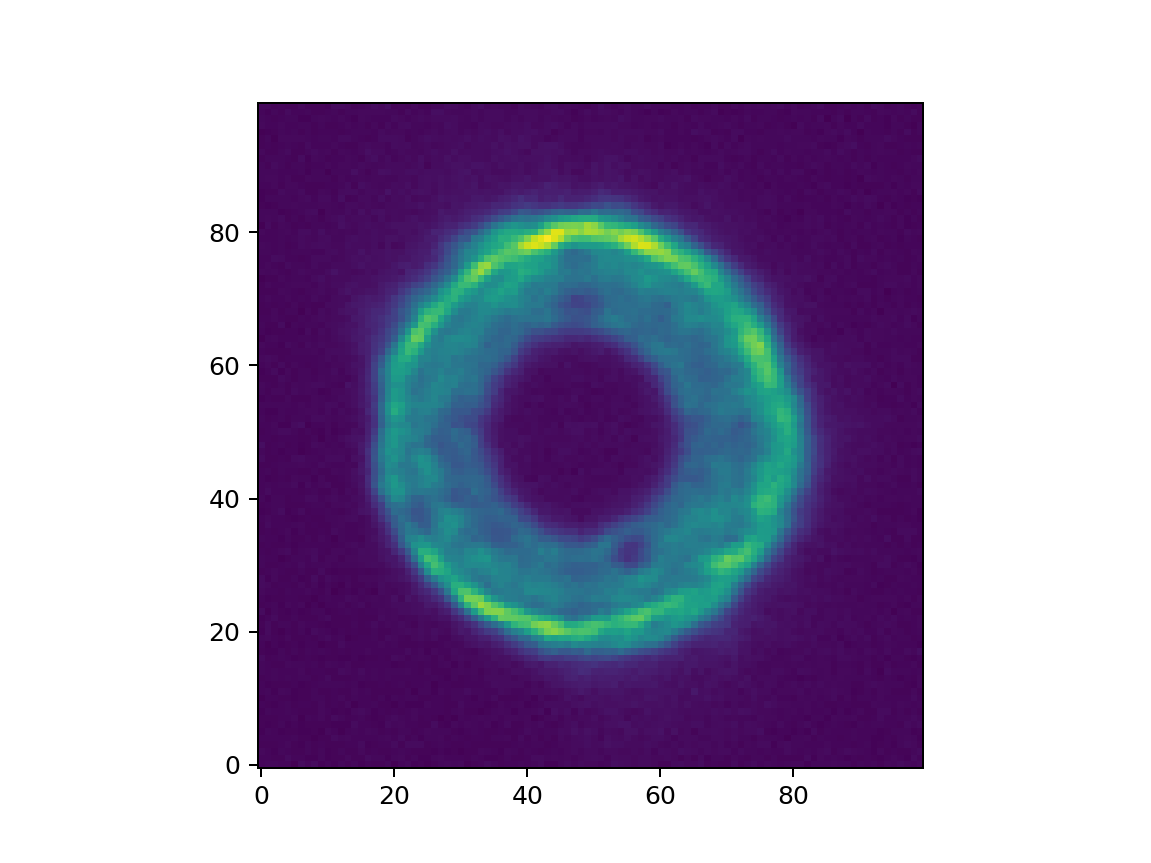

In [210]:
#plt.imshow(intra_whole[942-20:942+20,158-20:158+20], origin="lower")
#plt.imshow(extra_whole[945-20:945+20,154-20:154+20], origin="lower")
plt.imshow(intra, origin="lower")
plt.show()

<IPython.core.display.Javascript object>


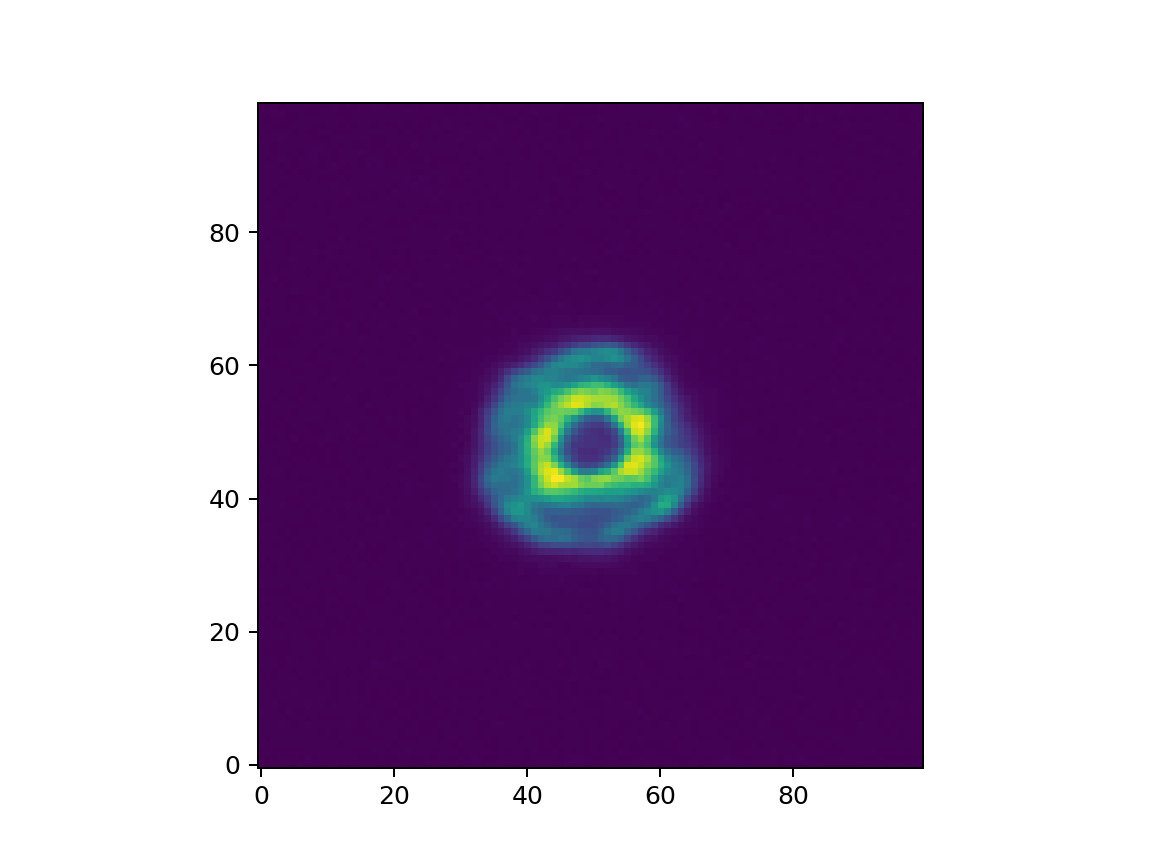

In [211]:
plt.imshow(extra, origin="lower")
plt.show()

In [99]:
fits.writeto("intra.fits", intra, overwrite=True)
fits.writeto("extra.fits", extra, overwrite=True)

These images are binned 3x3 so the pixels are 42 um. Thus the pupil diameter is:

In [10]:
pupsize = 25.25 * 3 * 14
pupsize * u.um

<Quantity 1060.5 um>

The mirror diameter is 1.54 meters and the focal ratio is 13.5. So the focal length is:

In [11]:
diameter = 1.54 * u.m
radius = diameter / 2.
focal_length = diameter * 13.5
focal_length

<Quantity 20.79 m>

Calculate the angle of beam convergence:

In [12]:
ang = np.arctan2(radius, focal_length)
ang

<Quantity 0.03702012 rad>

In [13]:
offset = pupsize / np.tan(ang) * u.um
offset

<Quantity 28633.5 um>

In [403]:
def kuiper_focus(pup_rad, focus, binning=3, direction='out'):
    pupsize = 14 * binning * pup_rad * u.um
    diameter = 1.54 * u.m
    radius = diameter / 2
    focal_length = diameter * 13.5
    beam_ang = np.arctan2(radius, focal_length)
    offset = pupsize / np.tan(beam_ang) * u.um
    counts_per_um = 600. / 23538.185  # empirically determined
    correction = offset.value * counts_per_um
    if 'out' in direction:
        correction *= -1
    return focus + correction

In [407]:
kuiper_focus(31, 2037, direction='in')

2933.092880568319

In [408]:
kuiper_focus(10.5, 3237, direction='out')

2933.4846694849243

So about 14 mm of focus offset at focal plane for 300 counts of focus change which gives 20 counts/mm. For motion at the secondary, scale by the ratio of the squares of the focal ratios:

In [16]:
counts_per_mm = 600. / offset.to(u.mm).value
counts_per_mm_m2 = counts_per_mm / (13.5**2 / 4.**2)
counts_per_mm, counts_per_mm_m2

(20.954476400020955, 1.8396248142679577)

In [86]:
obscuration = 0.5 * 0.4096 / 1.54
obscuration

0.132987012987013

In [18]:
nmperrad = radius.to(u.nm).value
nmperasec = nmperrad / 206265.
nmperasec

3733.061837926938

In [227]:
fieldXY = [0., 0.]
#I1 = Image(readFile("intra.fits"), fieldXY, Image.INTRA)
#I2 = Image(readFile("extra.fits"), fieldXY, Image.EXTRA)
I1 = Image(intra, fieldXY, Image.INTRA)
I2 = Image(extra, fieldXY, Image.EXTRA)

<IPython.core.display.Javascript object>


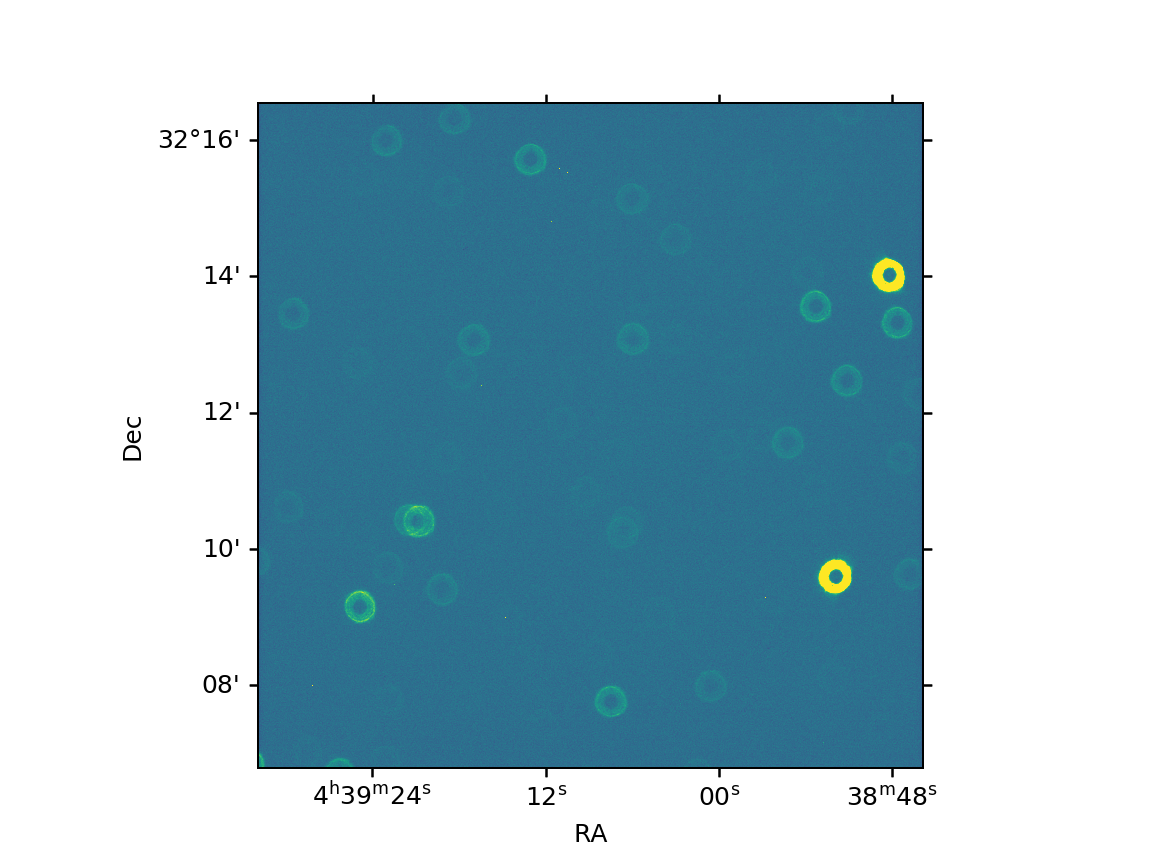

In [228]:
fig, ax = plt.subplots()
im = ax.imshow(I2.image, origin='lower', cmap='RdBu')
cbar = fig.colorbar(im)
fig.show()

In [229]:
kuiper = Instrument('61inch', I1.sizeinPix)

#kuiper.offset = offset.to(u.m).value  # needs to be focus offset between intra and extra positions
kuiper.offset = 1. * kuiper.offset
#kuiper.obscuration = 0.5 * kuiper.obscuration
kuiper.offset

0.028634

In [238]:
algo = Algorithm('exp.focus', kuiper, 3)

In [239]:
algo.runIt(kuiper, I1, I2, 'onAxis')

resetting images: I1 and I2
resetting images, inside
imageCoCenter: (x1,y1)=(   50.59,   50.17)

imageCoCenter: (x1,y1)=(   50.68,   50.31)

itr = 0, z4-z4
[-2014.]
itr = 1, z4-z4
[-2144.]
itr = 2, z4-z4
[-2292.]
itr = 3, z4-z4
[-2387.]
itr = 4, z4-z4
[-2464.]
itr = 5, z4-z4
[-2531.]
itr = 6, z4-z4
[-2570.]
itr = 7, z4-z4
[-2608.]
itr = 8, z4-z4
[-2635.]
itr = 9, z4-z4
[-2646.]
itr = 10, z4-z4
[-2661.]
itr = 11, z4-z4
[-2659.]
itr = 12, z4-z4
[-2670.]
itr = 13, z4-z4
[-2676.]
itr = 14, z4-z4
[-2669.]


In [76]:
print(algo.zer4UpNm)

[-581.50809706    9.01991611  300.66353045   60.86313127   79.56588597
   96.62188245 -353.80499839  -59.60733195  198.92529402   13.28839383
  184.54448744   88.36048721  -95.30932463  -42.09373979  -97.9105085
 -122.88128851 -103.13568696   63.46313611    2.37461178]


In [25]:
plots.plotZer(algo.zer4UpNm, 'nm')

In [236]:
zv = ZernikeVector()
zv.from_array(algo.zer4UpNm, modestart=4, normalized=True)
zv.denormalize()
zv

Fringe Coefficients
 Z04:                 -4206 nm 	 Defocus (2, 0)
 Z05:                   155 nm 	 Primary Astig at 45° (2, -2)
 Z06:                   501 nm 	 Primary Astig at 0° (2, 2)
 Z07:                 248.7 nm 	 Primary Y Coma (3, -1)
 Z08:                   136 nm 	 Primary X Coma (3, 1)
 Z09:                 415.2 nm 	 Y Trefoil (3, -3)
 Z10:                -160.9 nm 	 X Trefoil (3, 3)
 Z11:                 317.6 nm 	 Primary Spherical (4, 0)
 Z12:                -84.19 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:                -38.23 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:                  -165 nm 	 X Tetrafoil (4, 4)
 Z15:                -82.74 nm 	 Y Tetrafoil (4, -4)
 Z16:                 6.317 nm 	 Secondary X Coma (5, 1)
 Z17:                -17.84 nm 	 Secondary Y Coma (5, -1)
 Z18:                  33.1 nm 	 Secondary X Trefoil (5, 3)
 Z19:                -29.57 nm 	 Secondary Y Trefoil (5, -3)
 Z20:                 26.77 nm 	 X Pentafoil (5, 5)
 Z21:    

<IPython.core.display.Javascript object>


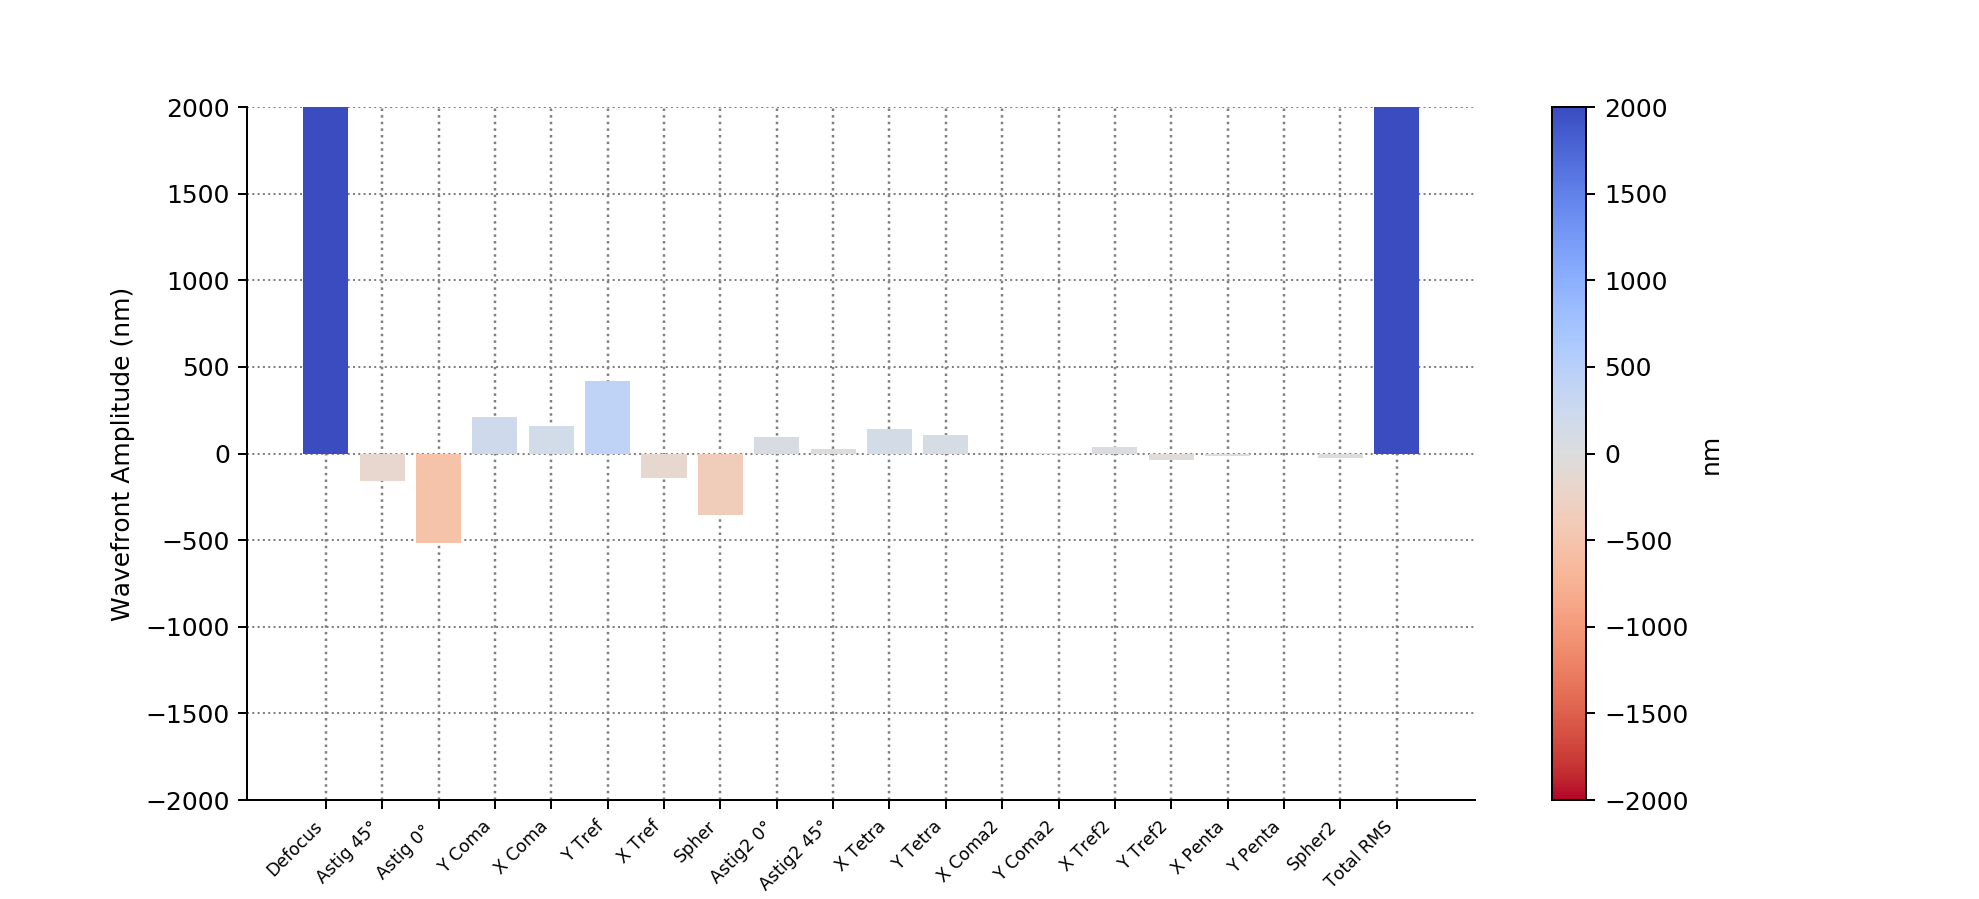

In [197]:
zv.fringe_bar_chart().show()
plt.show()

<IPython.core.display.Javascript object>


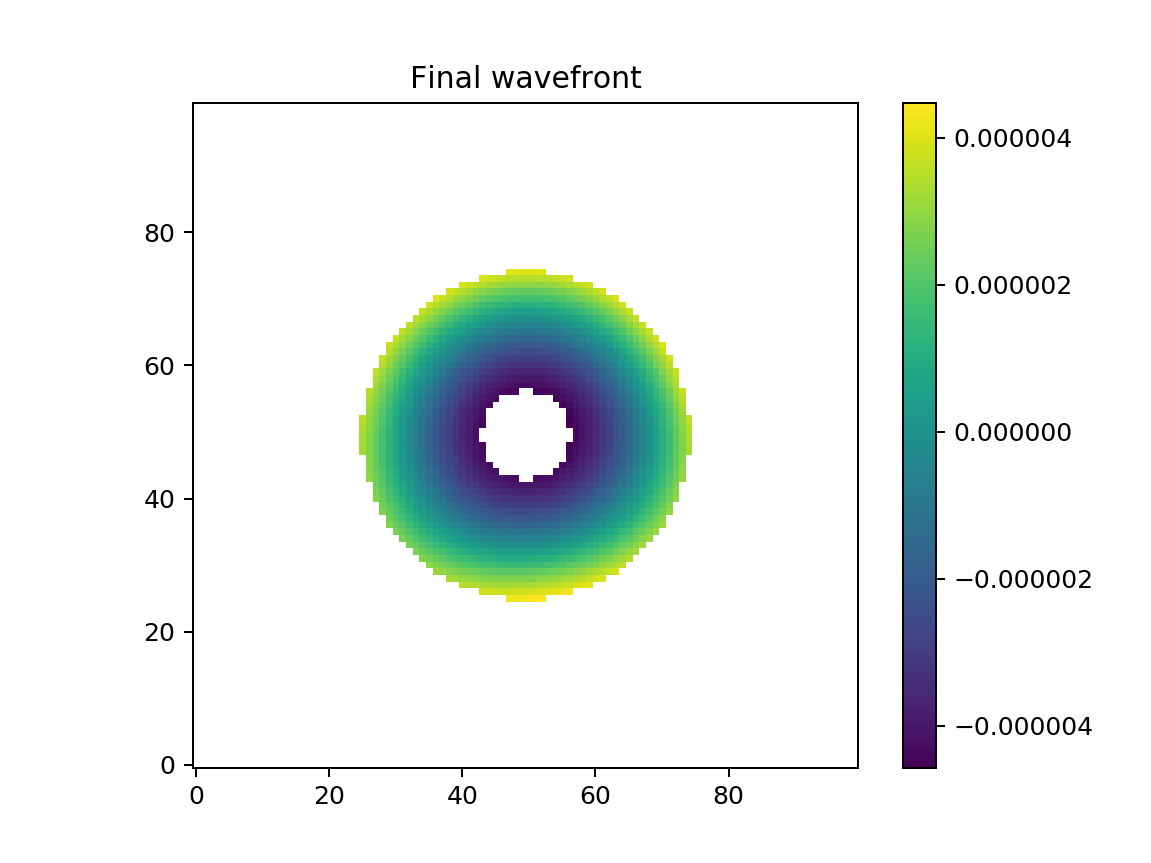

In [198]:
plots.plotImage(algo.Wconverge, "Final wavefront", show=True)

In [237]:
plt.imshow(algo.image)
plt.show()

AttributeError: 'Algorithm' object has no attribute 'image'

In [ ]:
plt.close('all')

Scaling seems wrong so try to calculate offset for MMT same way...

In [30]:
pupsize = 135. * 26.
diameter = 6.5 * u.m
radius = diameter / 2.
focal_length = diameter * 5.3
mmt_ang = np.arctan2(radius, focal_length)
offset = 0.5 * pupsize / np.tan(mmt_ang) * u.um
offset

<Quantity 18603. um>

OK, this matches what we're using there.

Use the Z04 term from the CWFS fit and see if we can calculate a focus correction

In [178]:
# this calculates the difference in size between in-focus pupil and observed in um
foc_err = (zv['Z04'] / (nmperasec * u.nm / u.arcsec)) * (100 * u.um / u.arcsec)

# use the tangent of the beam angle to convert pupil size difference to shift in focus position at focal plane.
# convert to focus counts and negate to create correction to send to telescope.
foc_corr = -counts_per_mm * foc_err.to(u.mm).value / np.tan(ang)
foc_corr

<Quantity 62.06399417>

In [329]:
from astropy.nddata import CCDData, Cutout2D
from artnfocus.imutils import ARTNreduce, sub_background, find_donuts, cutout_donuts

<IPython.core.display.Javascript object>


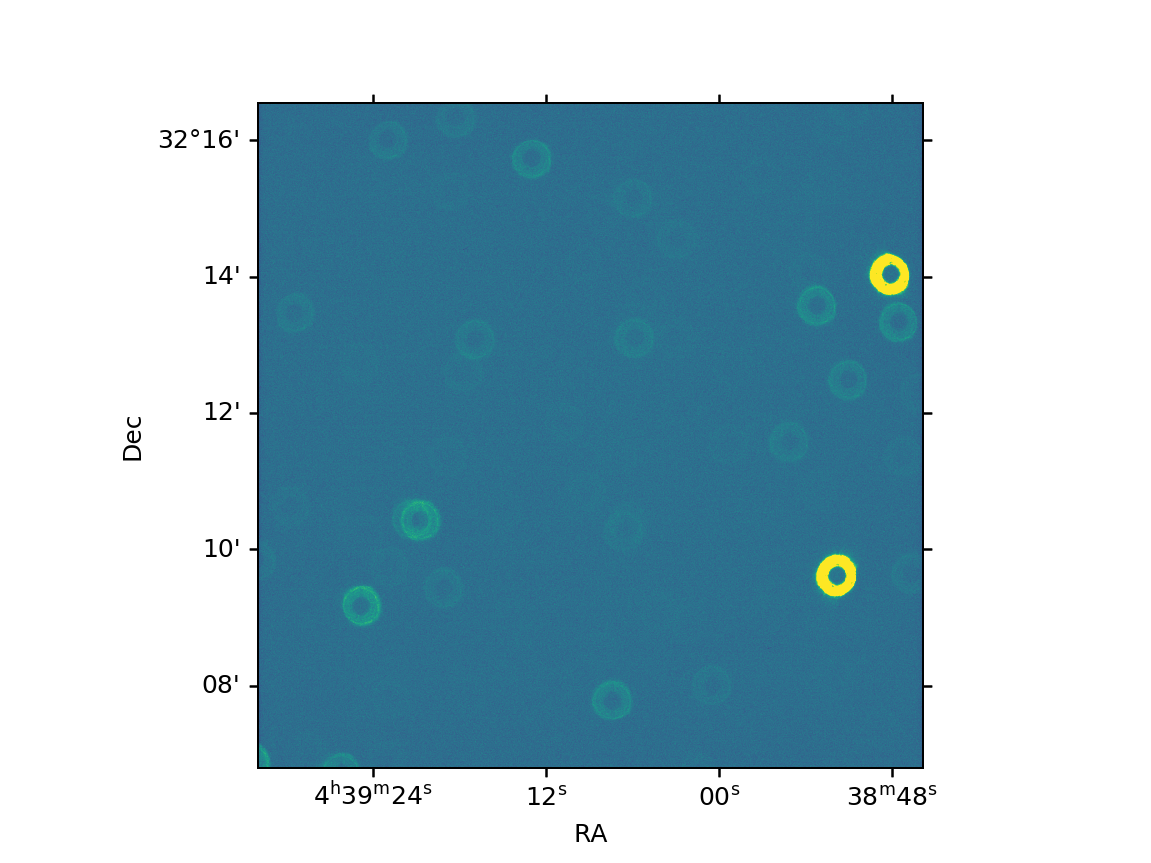

In [371]:
im = ARTNreduce("focus0003.fits")
im.data = sub_background(im)
norm = wfs_norm(im)
plt.subplot(projection=im.wcs)
plt.imshow(im, origin='lower', norm=norm)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

<IPython.core.display.Javascript object>


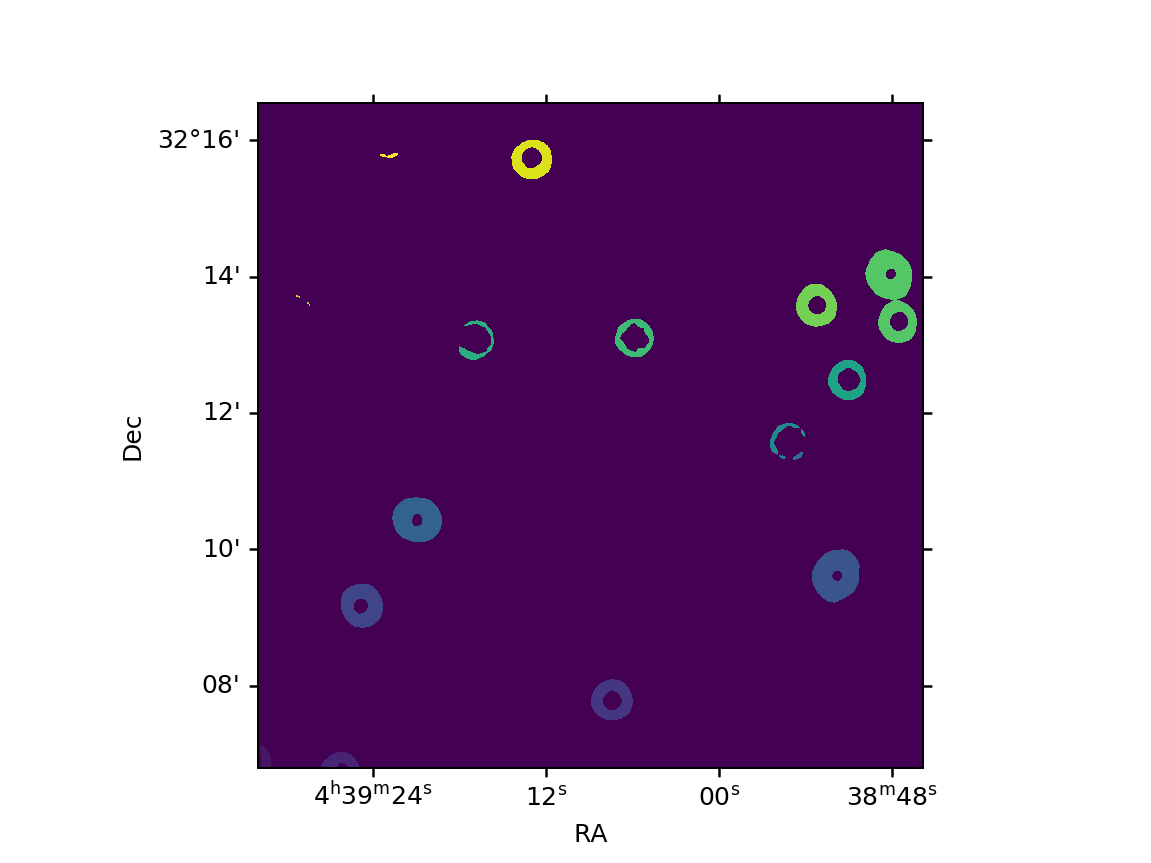

In [372]:
segm, cat = find_donuts(im)
plt.subplot(projection=im.wcs)
plt.imshow(segm, origin='lower')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [345]:
clean_cat, cutouts, fwhm = cutout_donuts(im, cat)
len(cutouts)

26

<IPython.core.display.Javascript object>


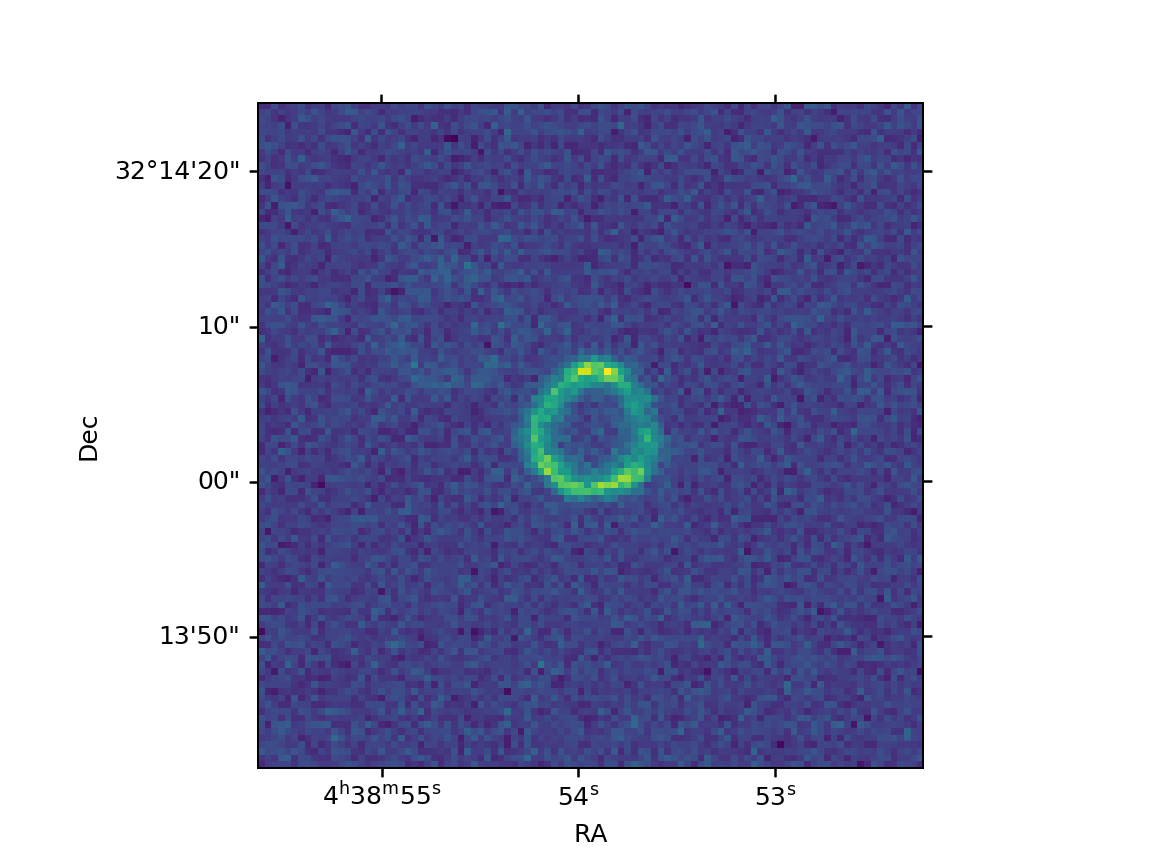

In [351]:
cout = cutouts[20]
plt.subplot(projection=cout.wcs)
plt.imshow(cout.data, origin='lower')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

<IPython.core.display.Javascript object>


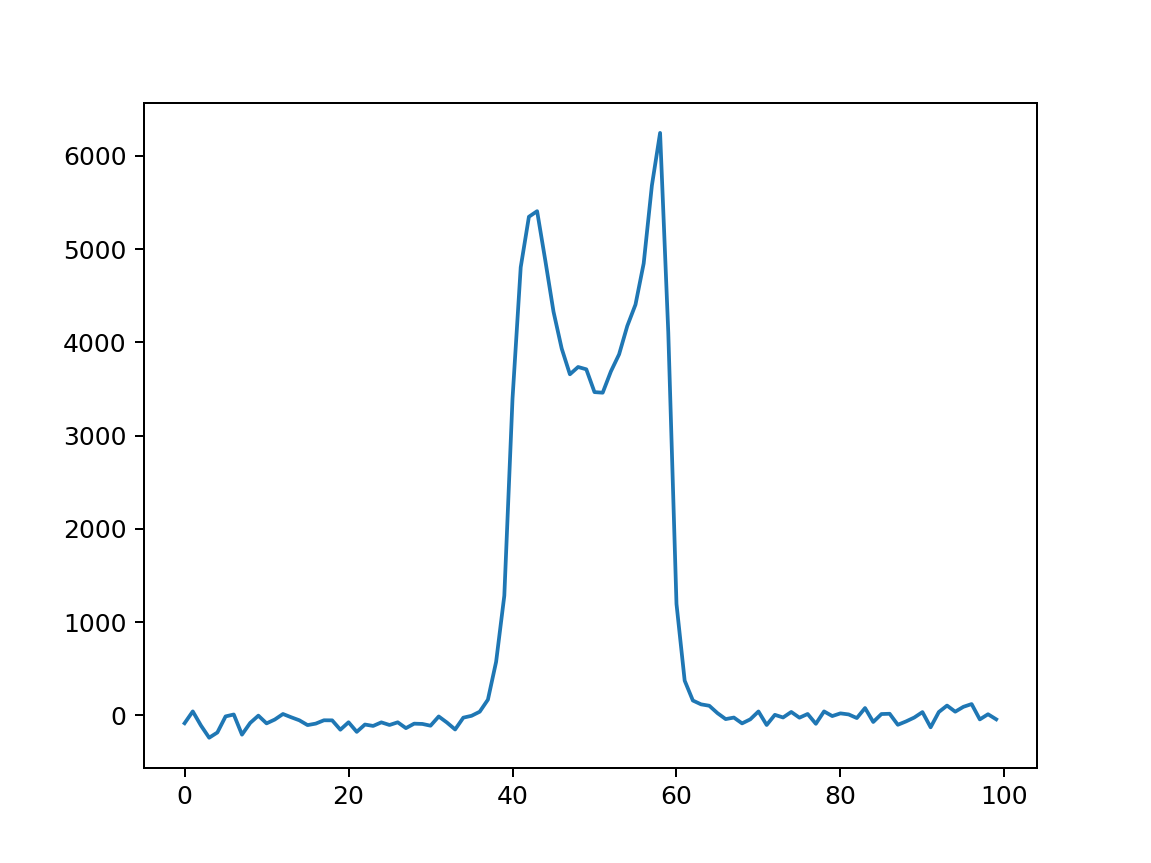

In [348]:
x = np.sum(cout.data, axis=1)
plt.plot(x)
plt.show()

In [349]:
fwhm

18.5

In [360]:
hlist = fits.open("focusinit.fits")
int(hlist[0].header['FOCUS'])

2637

In [375]:
focus_vals = []
widths = []
p = Path(".")
files = p.glob("focus*.fits")
for f in sorted(files):
    with fits.open(f) as hlist:
        focus = int(hlist[0].header['FOCUS'])
        focus_vals.append(focus)
    im = ARTNreduce(f)
    im.data = sub_background(im)
    segm, cat = find_donuts(im)
    clean_cat, cutouts, fwhm = cutout_donuts(im, cat)
    widths.append(fwhm)
    print(focus, fwhm)

2038 61.75
3236 21.0
2638 19.0
1838 76.0
3436 35.25
3636 48.5
1638 88.0
2736 13.0
2799 8.5
2637 18.5


<IPython.core.display.Javascript object>


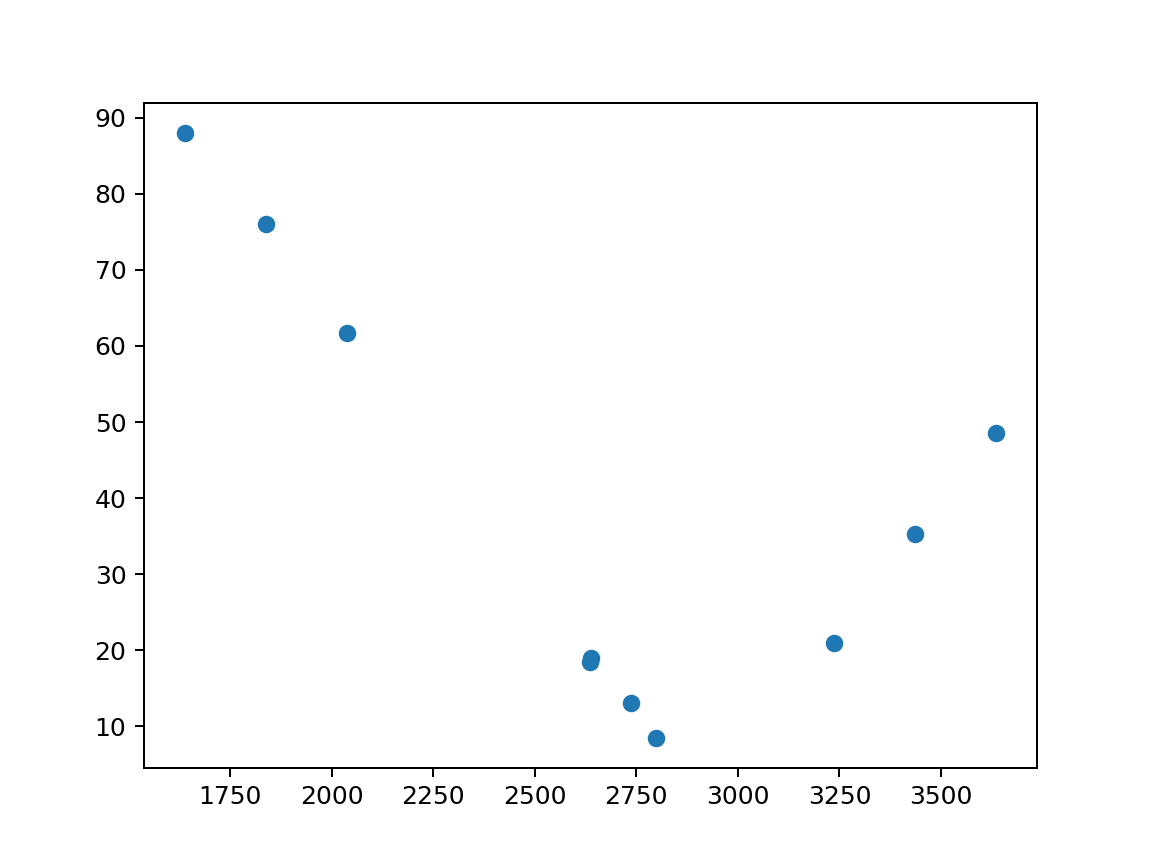

In [381]:
focus_vals = np.array(focus_vals)
widths = np.array(widths)
plt.scatter(focus_vals, widths)
plt.show()

In [385]:
intra_foc = focus_vals[focus_vals < 3000]
intra_width = widths[focus_vals < 3000]
extra_foc = focus_vals[focus_vals > 3000]
extra_width = widths[focus_vals > 3000]

<IPython.core.display.Javascript object>


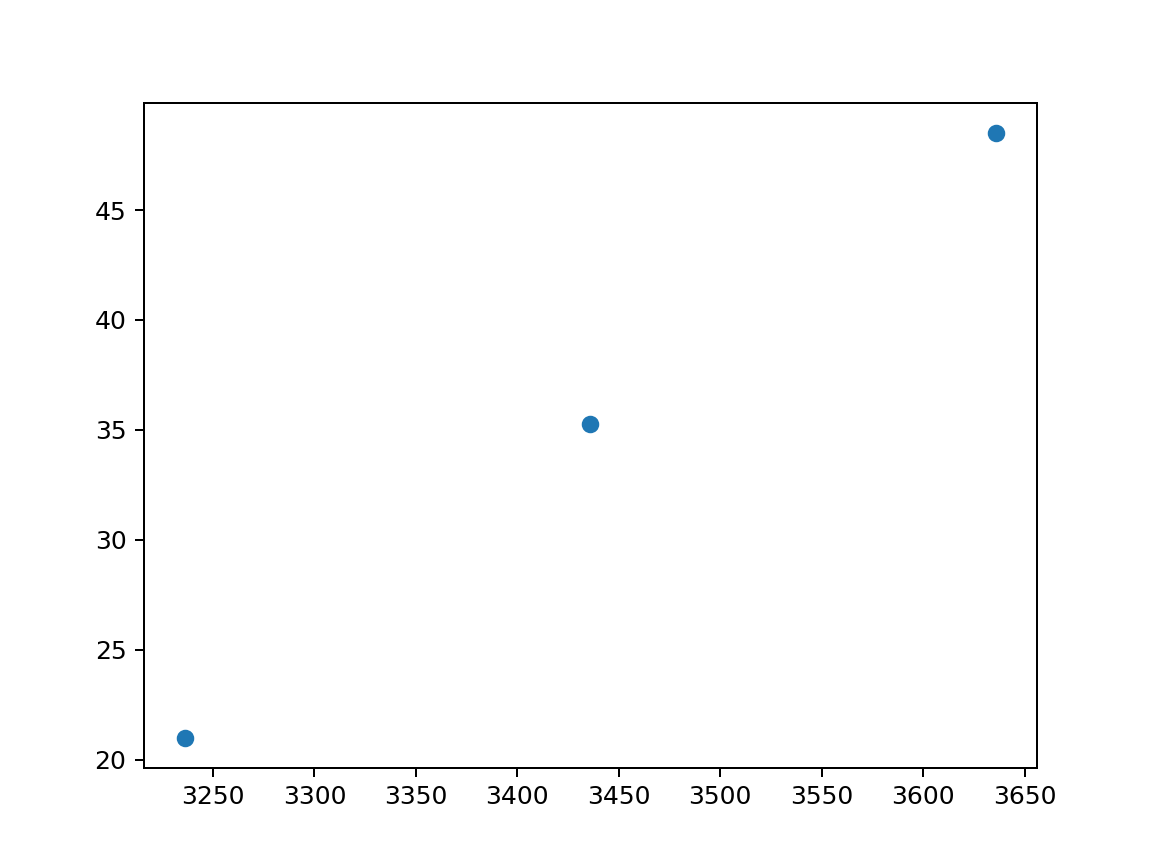

In [386]:
plt.scatter(extra_foc, extra_width)
plt.show()

In [417]:
from scipy.stats import linregress
from artnfocus.telescope import kuiper_mont4k

In [419]:
linregress(intra_width, intra_foc)

LinregressResult(slope=-14.354291872397523, intercept=2915.912087237885, rvalue=-0.999733961393192, pvalue=2.216938285126034e-09, stderr=0.14810535742200912)

In [420]:
linregress(extra_width, extra_foc)

LinregressResult(slope=14.539046150457098, intercept=2928.3449719132063, rvalue=0.9997796871530875, pvalue=0.013363585782067021, stderr=0.3052408075900746)

In [401]:
foc_slope = 0.5 * (0.06962851267395807 + 0.06875)  # pixels/foc adu
foc_slope = foc_slope * 14 * 3 # um/foc adu
offset_slope = 0.5 * foc_slope / np.tan(kuiper_mont4k.convergence_angle)

In [414]:
offset_slope * 600

<Quantity 23538.18500584>

In [418]:
kuiper_mont4k.offset_slope * 600

<Quantity 23538.438 um>

In [412]:
0.5 * (0.06962851267395807 + 0.06875) 

0.06918925633697903

In [423]:
'in' in ['out', 'inn']

False

In [428]:
kuiper_mont4k.simple_focus(35.25, 'extra') + 3436

2926.533314062726

In [431]:
focus_vals

array([2038, 3236, 2638, 1838, 3436, 3636, 1638, 2736, 2799, 2637])

In [433]:
for w, f in zip(intra_width, intra_foc):
    newf = kuiper_mont4k.simple_focus(w, 'intra') + f
    print(w, newf)

61.75 2930.470010117069
19.0 2912.6061569590984
76.0 2936.4246278363926
88.0 2909.860095389507
13.0 2923.888423182541
8.5 2921.8501228501227
18.5 2904.379679144385


In [434]:
for w, f in zip(extra_width, extra_foc):
    newf = kuiper_mont4k.simple_focus(w, 'extra') + f
    print(w, newf)

21.0 2932.4879317820496
35.25 2926.533314062726
48.5 2935.0316519728285
